In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [62]:
PATH_DATASET = '../protocols/labelled/massnahmen_relevant_bert_predictions.csv'
PATH_OPINIONS_PER_PARTY = '../results/opinion_measures_predicted_per_party.png'
PATH_OPINION_CONS_PER_PARTY = '../results/opinion_measures_predicted_consistency_over_time_per_party.png'

In [63]:
data = pd.read_csv(PATH_DATASET, sep='\t')
data.sort_values('Date', inplace=True)

In [64]:
data["opinion_integer"] = 0
data.loc[data['Opinion'] == '-', "opinion_integer"] = 0
data.loc[data['Opinion'] == 'o', "opinion_integer"] = 1
data.loc[data['Opinion'] == '+', "opinion_integer"] = 2
data.head()

,Unnamed: 0,Opinion,Context Used,Sentence Id,Date,Protocol Id,Party,Speaker,Governing,Speech,MASKS,LOCKDOWN,VACCINES,TESTING,DISTANCING,opinion_integer
4714,4714,+,True,2968,2019_11_13,3,Grüne,"Abgeordneter Hermann Weratschnig, MBA MSc (Grüne)",False,Wir brauchen Superheldinnen und Superhelden au...,False,False,False,True,False,2
3268,3268,+,False,6884,2019_12_11,6,ÖVP,Abgeordnete Mag. Michaela Steinacker (ÖVP),False,"Das ist eine gute Maßnahme, die auch wirklich ...",False,False,False,False,True,2
1001,1001,o,True,18698,2020_01_22,10,ÖVP,Abgeordneter Mag. Andreas Hanger (ÖVP),True,"Ich kenne auch die anderen Themen, die auf der...",False,False,True,False,False,1
546,546,-,True,23816,2020_02_27,12,FPÖ,Abgeordneter Herbert Kickl (FPÖ),False,Dazu höre ich aber nichts! Wahrscheinlich ist ...,True,False,False,False,False,0
4264,4264,+,True,23540,2020_02_27,12,ÖVP,"Bundesminister für Inneres Karl Nehammer, MSc",True,Ich darf Ihnen jetzt ein aktuelles Lagebild ge...,False,False,False,True,False,2


In [65]:
# total opinion consistency
opinion_counts = np.bincount(data['opinion_integer'])
total_opinion_cons = opinion_counts[[0,2]].max() / opinion_counts[[0,2]].sum()

In [66]:
dates = data['Date'].unique()
parties = data['Party'].unique()
speakers = data['Speaker'].unique()
speakers.sort()

In [67]:
opinions_per_party = {}
opinions_per_party_rel = {}
for party in parties:
    data_party = data[data['Party'] == party]
    opinion_counts = np.bincount(data_party['opinion_integer'], minlength=3)
    opinions_per_party[party] = opinion_counts
    opinions_per_party_rel[party] = opinion_counts / opinion_counts.sum()

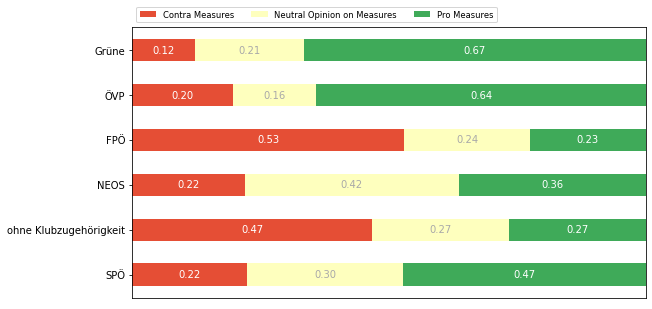

In [68]:
category_names = ["Contra Measures", "Neutral Opinion on Measures", "Pro Measures"]
results = opinions_per_party

def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        ax.bar_label(rects, fmt='%.2f', label_type='center', color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax


survey(opinions_per_party_rel, category_names)
plt.savefig(PATH_OPINIONS_PER_PARTY)
plt.show()

In [69]:
opinions_per_party_day = {party: [] for party in parties}
for date in dates:
    data_day = data[data['Date'] == date]

    for party in parties:
        data_day_party = data_day[data_day['Party'] == party]
        opinion_counts = np.bincount(data_day_party['opinion_integer'], minlength=3)
        opinions_per_party_day[party].append(opinion_counts)

opinion_consistency_per_party = {party: [] for party in parties}
for party in parties:
    opinions_per_day = opinions_per_party_day[party]
    cumulative_opinions = np.array([0,0,0])
    opinion_consistencies = []
    for opinions in opinions_per_day:
        cumulative_opinions += opinions
        opinion_consistency = cumulative_opinions[[0,2]].max() / cumulative_opinions[[0,2]].sum()
        opinion_consistencies.append(opinion_consistency)
    opinion_consistency_per_party[party] = opinion_consistencies

<ipython-input-69-edac474dccc7>:17: RuntimeWarning: invalid value encountered in long_scalars
  opinion_consistency = cumulative_opinions[[0,2]].max() / cumulative_opinions[[0,2]].sum()


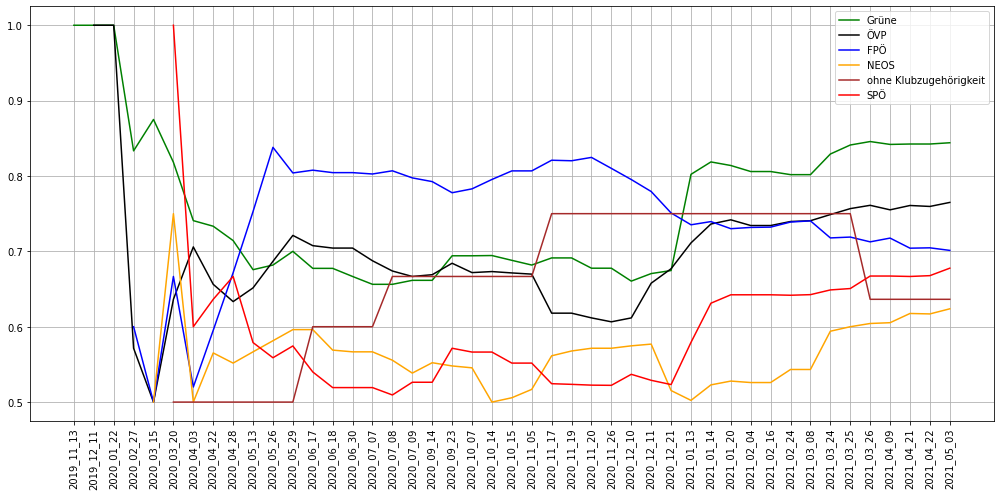

In [70]:
fig, ax = plt.subplots(figsize=(14, 7))

colors = {
    'SPÖ': 'red',
    'ÖVP': 'black',
    'NEOS': 'orange',
    'Grüne': 'green',
    'FPÖ': 'blue',
    'ohne Klubzugehörigkeit': 'brown'
}
for party in parties:
    ax.plot(dates, opinion_consistency_per_party[party], label=party, color=colors[party])

plt.xticks(dates, dates, rotation='vertical')


# Using plot(..., dashes=...) to set the dashing when creating a line
#line2, = ax.plot(x, y - 0.2, dashes=[6, 2], label='Using the dashes parameter')

ax.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(PATH_OPINION_CONS_PER_PARTY)
plt.show()